In [30]:
class_names = ["床面", "椅子", "収納", "玄関", "浴槽", "洗面台"]
num_classes = len(class_names) + 1

class_labels = {i: class_name for i, class_name in enumerate(class_names)}
class_ids = [i for i in range(len(class_names))]
class_to_index = {class_name: index for index, class_name in enumerate(class_names)}

def get_class_key(class_name):
    return class_names.index(class_name)


def get_class_name(class_key):
    return class_names[class_key]

In [3]:
import json
import os

image_dir = "dataset/Set_A_02/images"
images = [file for file in os.listdir(image_dir) if file.endswith(".jpg")]
annotation_dir = "dataset/annotations/"
mask_dir = "dataset/masks/"
annotations = [file for file in os.listdir(annotation_dir) if file.endswith(".json")]

In [6]:
from PIL import Image, ImageDraw
import os

def draw_polygons(image_size, annotations):
    """
    指定されたアノテーションデータに基づいて、画像上にポリゴンを描画します。
    Args:
    - image_size (tuple): 画像のサイズ（幅、高さ）
    - annotations (list of dicts): 各辞書には 'all_points_x' と 'all_points_y' のリストが含まれる

    Returns:
    - PIL.Image: ポリゴンが描画された画像
    """
    # 新しい白背景の画像を生成
    image = Image.new("RGB", image_size, "white")
    draw = ImageDraw.Draw(image)

    # アノテーションのリストをループし、ポリゴンを描画
    for annotation in annotations:
        shape_attr = annotation["shape_attributes"]
        # X座標とY座標のリストからタプルのリスト（頂点のリスト）を作成
        points = list(zip(shape_attr["all_points_x"], shape_attr["all_points_y"]))
        # ポリゴンを描画（黒色で塗りつぶし）
        draw.polygon(points, fill="red")

    return image

def saved_mask_img(image, file_path):
    directory = os.path.dirname(file_path)

    if not os.path.exists(directory):
        os.makedirs(directory)

    image.save(file_path)

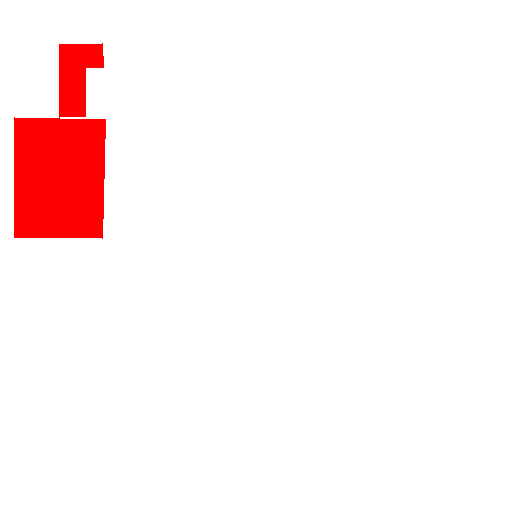

In [7]:
annotations = [
    {
        "shape_attributes": {
            "name": "polyline",
            "all_points_x": [14, 14, 102, 105],
            "all_points_y": [117, 237, 238, 119],
        },
        "region_attributes": {
            "floor_label": "洋室6帖",
            "class": "床面",
            "description": "洋室",
        },
    },
    {
        "shape_attributes": {
            "name": "polyline",
            "all_points_x": [59, 59, 85, 85, 103, 102],
            "all_points_y": [44, 117, 116, 67, 67, 43],
        },
        "region_attributes": {
            "floor_label": "K2",
            "class": "床面",
            "description": "K2",
        },
    },
]

image = draw_polygons((512, 512), annotations)
image.show()
saved_mask_img(image, './dataset/mask_images/msk_01.png')

In [32]:
from torch.utils.data import Dataset, DataLoader
import torch
from PIL import Image
import os
import json

class PolyLineDataset(Dataset):
    def __init__(
            self,
            image_dir: str,
            mask_dir: str,
            annotation_dir: str,
            transform=None,
        ) -> None:
        super().__init__()
        self.image_dir = image_dir
        self.transform = transform
        self.annotation_dir = annotation_dir
        self.mask_dir = mask_dir
        self.images = [file for file in os.listdir(image_dir) if file.endswith(".jpg")]
        self.annotations = [file for file in os.listdir(self.annotation_dir) if file.endswith(".json")]

    def __getitem__(self, index):
        annotation_path = os.path.join(self.annotation_dir, self.annotations[index])
        image_path, filename = self._get_target_image_path(annotation_path)
        mask_path = os.path.join(self.mask_dir, filename) + "_mask.jpg"

        if not os.path.exists(mask_path):
            print("WARNING: mask file not found: ", mask_path)
            self._create_polygon_image(image_path, annotation_path, mask_path)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

    def __len__(self):
        return len(self.image_paths)

    def _create_polygon_image(self, image_path, annotation_path, mask_path):
        image = Image.open(image_path).convert("RGB")
        annotation = self._load_annotation(annotation_path)
        mask_image = Image.new("RGB", image.size, "white")
        draw = ImageDraw.Draw(mask_image)

        for i, data in annotation.items():
            for region in data['regions']:
                shape_attr = region['shape_attributes']
                if shape_attr['name'] != 'polyline':
                    continue

                all_pointsX = shape_attr['all_points_x']
                all_pointsY = shape_attr['all_points_y']
                points = list(zip(all_pointsX, all_pointsY))
                draw.polygon(points, fill="red")

        if  not os.path.exists(os.path.dirname(mask_path)):
            os.makedirs(os.path.dirname(mask_path))

        mask_image.save(mask_path)

    def _get_target_image_path(self, annotation_path):
        annotation = self._load_annotation(annotation_path)

        for i, data in annotation.items():
            for image in self.images:
                image_file = image.split("/")[-1]
                if data["filename"] == image_file:
                    image_path = os.path.join(self.image_dir, image)
                    filename = image_file.split('.')[0]

                    return image_path, filename

        return None

    def _load_annotation(self, annotation_path):
        with open(annotation_path, "r") as f:
            annotation = json.load(f)
        return annotation


In [34]:
dataset = PolyLineDataset(image_dir, mask_dir, annotation_dir)
dataset[1]

[(14, 117), (14, 237), (102, 238), (105, 119)]
[(59, 44), (59, 117), (85, 116), (85, 67), (103, 67), (102, 43)]


(<PIL.Image.Image image mode=RGB size=158x280>,
 <PIL.Image.Image image mode=RGB size=158x280>)

In [10]:
from torch import nn
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn

def pretrained_model(class_names):
    model = maskrcnn_resnet50_fpn(pretrained=True)
    num_classes = len(class_names) + 1
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    return model

In [18]:
from torch import nn
from torch.nn.utils.rnn import pad_sequence
import torch

def train_model(
        model: nn.Module, 
        dataloader: DataLoader, 
        optimizer: torch.optim.Optimizer,
        num_epochs=25
    ):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    model.train()
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        for sample in dataloader:
            optimizer.zero_grad()
            print(sample)


In [198]:
def evaluate_model(model: nn.Module, dataloader: DataLoader, criterion_labels: nn.Module, criterion_polygons: nn.Module):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    total_loss = 0.0
    total_mae = 0.0
    num_batches = 0

    with torch.no_grad():
        for images, labels, polygons in dataloader:
            images = images.to(device)
            labels = torch.tensor(labels, dtype=torch.long).to(device)
            polygons = [torch.tensor(p, dtype=torch.float32) for p in polygons]
            polygons = pad_sequence(polygons, batch_first=True, padding_value=0).cuda()
            polygons = polygons.permute(0, 2, 1)
            outputs = model(images)
            output_labels = outputs[:, :len(class_names)]
            output_polygons = outputs[:, len(class_names):]

            loss = criterion_labels(output_labels, labels) + criterion_polygons(output_polygons, polygons)
            total_loss += loss.item()

            mae = torch.mean(torch.abs(outputs - polygons))
            total_mae += mae.item()

            num_batches += 1

    average_loss = total_loss / num_batches
    average_mae = total_mae / num_batches

    print(f"Average Loss: {average_loss:.2f}, Average MAE: {average_mae:.2f}")
    return average_loss, average_mae

In [19]:
from torchvision import transforms

transform = transforms.Compose({
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
})

dataset = PolyLineDataset(image_dir, annotation_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

model = pretrained_model(class_names=class_names)
train_model(model, dataloader, optimizer=torch.optim.Adam(model.parameters()))


/home/onikarubi/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/onikarubi/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/24
----------


TypeError: Unexpected type <class 'dict'>

In [185]:
test_loader = DataLoader(dataset, batch_size=1, shuffle=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

results = evaluate_model(model, test_loader, criterion)
results

Average Loss: 4943.78, Average MAE: 57.74


(4943.776123046875, 57.73758316040039)